# Jeans Analysis tutorial

In this notebook, we apply Jeans modeling to estimate the DM density profile at the center of a dwarf galaxy.
We model the DM density profile as the generalized NFW profile and use Dynamic Nested Sampling (dynesty) to sample th joint posterior distritbutions of its three parameters.

In [77]:
import os
import h5py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy
import astropy.units as u
import astropy.constants as const

import dynesty
import dynesty.plotting
import corner



%matplotlib inline

mpl.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 20,
    'font.family': 'STIXGeneral',
    'figure.figsize': (8, 6),
    'figure.facecolor': 'w',
    'axes.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

## Read in the stellar coordinate of a galaxy
Read in the position and velocity of stars in a given dwarf galaxy

### Using StarSampler to generate a dwarf galaxy with the OM profile

In [2]:
from StarSampler import sfw, osipkov_merritt, star_sampler

In [3]:
# Define DM and star parameters
rs = 1
gamma = 0
rho0 = 6.7e7
logrho_0 = np.log10(rho0)
ra = 1e30
rs_s = 1
N_star = 100
model_param = dict(
    al_s=2., be_s=5., ga_s=0.1, ra=ra, rs_s=rs_s, # star density parameters
    alpha=1, beta=3, rho=rho0, rs=rs, gamma=gamma  # generalized NFW parameters
)
profile = osipkov_merritt.OM(**model_param)

# generate samples
samples = profile.conditional_sample(N_star, r_vr_vt=True)
truth_dm_params = np.array([rs, gamma, logrho_0])
truth_star_params = np.array([N_star, rs_s])

Calculating f(Q) function... 
    Finish calculating f(Q). Time used (sec):  10.391633987426758
samples accepted:  100
OM sample time (sec):  0.6229038238525391


In [4]:
X, Y, _, _, _, v = samples

# also save full data
np.savetxt('example_data_1.txt', samples.T, 
           header='x[kpc] y[kpc] z[kpc] vx[km/s] vy[km/s] vz[km/s]')

### Read in the coordinates from a text file

In [5]:
X, Y, _, _, _, v = np.genfromtxt('example_data_1.txt', unpack=True) 

## Light profile fitting

In this section, we fit the 2D Plummer profile

In [6]:
def poiss_err(n, alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in 
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3
    :param: alpha corresponds to central confidence level 1-alpha, 
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = scipy.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = scipy.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

def log10_plummer2d(R, params):
    """ Log 10 of the Plummer 2D profile
    Args:
        R: projected radius
        params: L, a
    Returns:
        log I(R) = log {L(1 + R^2 / a^2)^{-2} / (pi * r_star^2)}
    """
    logL, logr_star = params
    r_star = 10**logr_star
    return logL - 2 * logr_star - 2 * np.log10(1 + R**2 / r_star**2) - np.log10(np.pi) 


def log10_plummer3d(r, params):
    """ Log 10 of the Plummer 2D profile
    Args:
        R: projected radius
        params: L, r_star
    Returns:
        log I(R) = log {L(1 + R^2 / a^2)^{-2} / (pi * r_star^2)}
    """
    logL, logr_star = params
    r_star = 10**logr_star 
    return logL - 3 * logr_star - (5/2) * np.log10(1 + r**2 / r_star**2) - np.log10(4 * np.pi / 3)

def calc_nstar(R):
    ''' Calculate the projected number of stars as a function of projected radius R'''
    # calculate the projected radius
    logR = np.log10(R)
    N_star = len(R)
    
    # binning
    nbins = int(np.ceil(np.sqrt(N_star))) 
    logR_min = np.floor(np.min(logR)*10) / 10
    logR_max = np.ceil(np.max(logR)*10) / 10
    n_data, logR_bins = np.histogram(logR, nbins, range=(logR_min, logR_max))
    
    # ignore bin with zero count
    select = n_data > 0 
    n_data = n_data[select]
    logR_bins_lo = logR_bins[:-1][select]
    logR_bins_hi = logR_bins[1:][select]

    # compute poisson error 
    n_data_lo, n_data_hi = poiss_err(n_data, alpha=0.32)
    
    return n_data, n_data_lo, n_data_hi, logR_bins_lo, logR_bins_hi

def calc_Sigma(R):
    ''' Calculate the projected 2d light profile Sigma(R) where R is the projected radius '''
    n_data, n_data_lo, n_data_hi, logR_bins_lo, logR_bins_hi =  calc_nstar(R)
    R_bins_lo = 10**logR_bins_lo
    R_bins_hi = 10**logR_bins_hi
    R_bins_ce = 0.5 * (R_bins_lo + R_bins_hi)

    # light profile
    delta_R2 = (R_bins_hi**2 - R_bins_lo**2)
    Sig_data = n_data / (np.pi * delta_R2)
    Sig_data_lo = n_data_lo / (np.pi * delta_R2)
    Sig_data_hi = n_data_hi / (np.pi * delta_R2)
    
    return Sig_data, Sig_data_lo, Sig_data_hi, R_bins_ce

In [7]:
R = np.sqrt(X**2 + Y**2)
Sig_data, Sig_data_lo, Sig_data_hi, R_ce = calc_Sigma(R)

# error
sig_lo = Sig_data - Sig_data_lo
sig_hi = Sig_data_hi - Sig_data
V1 = sig_lo * sig_hi
V2 = sig_hi - sig_lo

In [8]:
def loglike(x):
    """ The log-likelihood function. """
    # estimate the count
    Sig_hat = 10**log10_plummer2d(R_ce, x)    
    # calculate log likelihood
    denom = V1 - V2 * (Sig_data - Sig_hat)
    numer = (Sig_data - Sig_hat)**2
    return -0.5 * np.sum(numer / denom)

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit to our prior"""
    u[0] = (5 + 2) * u[0] - 2
    u[1] = (3 + 3) * u[1] - 3
    return u

# "Dynamic" nested sampling.
sampler = dynesty.DynamicNestedSampler(loglike, ptform, 2, nlive=1000)
sampler.run_nested()
results = sampler.results
weights =  np.exp(results.logwt - results.logz[-1])

19466it [00:30, 644.86it/s, batch: 4 | bound: 2 | nc: 1 | ncall: 59582 | eff(%): 32.671 | loglstar: -4.680 < -1.510 < -4.278 | logz: -9.518 +/-  0.063 | stop:  0.934]               


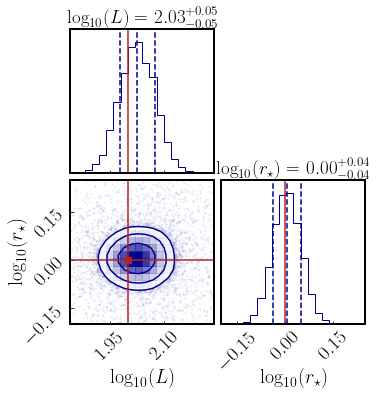

In [13]:
plot_labels = (r'$\log_{10} (L) $', r'$\log_{10} (r_\star)$')

fig = corner.corner(
    results.samples, weights=weights, truths=np.log10(truth_star_params),
    truth_color='firebrick', color='darkblue', range=((1.84, 2.24), (-0.2, 0.25)),
    quantiles=[0.16, 0.5, 0.84],plot_datapoints=True, smooth=True, max_n_ticks=4, 
    show_titles=True, title_kwargs={"fontsize": 19}, 
    labels=plot_labels, fontsize=20
)

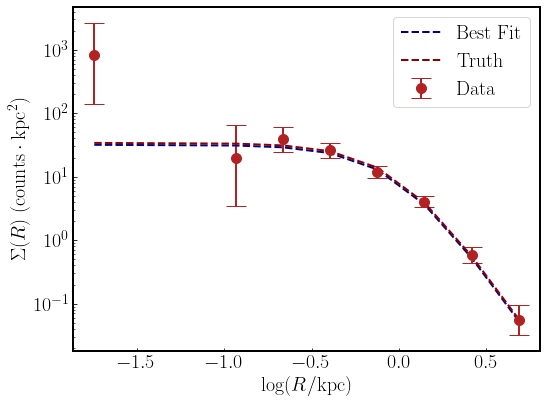

In [67]:
fig, ax = plt.subplots(1)

star_params = (2.03, 0.0)
Sigma_truth = 10**log10_plummer2d(R_ce, np.log10(truth_star_params))
Sigma_best_fit = 10**log10_plummer2d(R_ce, star_params)

ax.errorbar(
    np.log10(R_ce), Sig_data, 
    yerr=(Sig_data - Sig_data_lo, Sig_data_hi - Sig_data), 
    color='firebrick', lw=2, ms=20, fmt='.', capsize=10, label='Data'
)
ax.plot(
    np.log10(R_ce), Sigma_truth,
    color='darkblue', ls='--', lw=2, label='Best Fit',
)
ax.plot(
    np.log10(R_ce), Sigma_best_fit,
    color='darkred', ls='--', lw=2, label='Truth',
)
ax.set_yscale('log')
ax.set_xlabel(r'$\log(R/\mathrm{kpc})$ ')
ax.set_ylabel(r'$\Sigma(R)$ ($\mathrm{counts} \cdot \mathrm{kpc}^2$)')
ax.legend()

fig.tight_layout()

## DM Fit

In [15]:
# Define conversion factor and constant
G = const.G.to_value(u.kpc**3 / u.Msun / u.s**2)
kpc_to_km = (u.kpc).to(u.km)

In [74]:
def gNFW(r, rs, gamma, logrho_0):
    ''' Generalized NFW profile '''
    return 10**logrho_0 * (r/rs)**(-gamma) * (1  + r/rs)**(-3 + gamma)

def cumulative_mass(r, rho, axis=0):
    ''' Compute the enclosed mass cumulatively at each radius '''
    dr = r[1] - r[0]
    M = scipy.integrate.cumulative_trapezoid(
        4 * np.pi * r**2 * rho, axis=axis, dx=dr)
    M = np.append(M, M[-1])
    return M

def calc_sigma2_nu(r, nu, dm_params):
    ''' Calculate the 3D Jeans integration:
    ```
    sigma2(r0) nu(r0) = int_r0^\infty G M(r) nu(r) / r^2 dr 
    ```
    where:
    - G is the gravitational constant
    - M(r) is the enclosed radius at radius r in Msun
    - nu(r) is the 3D light profile

    Parameters:
    - r: (array of M float) the 3d radii 
    - nu: (array of M float) the 3d light profile at each radius
    - dm_params: (array of 3 float) the gNFW parameters (r_dm, gamma, rho0)
        r_dm in unit of kpc, rho0 in unit of Msun / kpc^3

    Returns:
    - sigma2: (arrays of M floats) the 3D velocity dispersion in (km/s)^2 
    '''
    rho = gNFW(r, *dm_params)
    M = cumulative_mass(r, rho)
    dr = r[1] - r[0]

    # integration
    inte = M * G * nu / r**2
    sigma2_nu = scipy.integrate.cumulative_trapezoid(
        inte[::-1], dx=dr, initial=0)[::-1]

    return sigma2_nu

def calc_sigma2p_Sigma(R, r, sigma2_nu):
    ''' Calculate the projected Jeans integration:
    ```
    sigma2_p(R) Sigma(R) = 2 * int_R^\intfy (nu(r) sigma2(r) r) / sqrt(r^2 - R^2) dr 
    ```
    where:
    - R is the projected radius
    - Sigma(R) is the 3D light profile

    Parameters:
    - R: (array of M float) the 2d projected radii 
    - r: (array of N float) the 3d projected radii for integration
    - sigma2_nu: (array of N float) the 3d Jeans integration at each 3d projected radii
    Returns:
    - sigma2_p: (arrays of M floats) the 2D velocity dispersion

    '''
    dr = r[1] - r[0]
    rminR2 = r[None, :]**2 - R[:, None]**2

    # integrate
#     inte = np.zeros_like(rminR2)
#     inte[rminR2 > 0] = (sigma2_nu * r).reshape(1, -1) / np.sqrt(rminR2) 
    inte = (sigma2_nu * r)
    inte = np.where(rminR2 > 0, inte[None, :] / np.sqrt(rminR2), 0)
    sigma2p_Sigma = 2 * scipy.integrate.trapezoid(inte, axis=1, dx=dr)

    return sigma2p_Sigma

In [71]:
class JeansModel():
    ''' Class for fitting DM density distribution with Jeans modeling '''
    def __init__(
        self, R, v, logL, logr_star, priors, dr=0.001, v_err=0.0, r_max_factor=2):
        ''' 
        Parameters:
        - R: (array of N float) the prosjected radii of N stars in kpc
        - v: (array of N float) the line-of-sight velocities of N stars in km/s
        - v_err: (array of N float) the velocity measurement error of N stars
        - logL: (float) Plummer luminosity in Lsun
        - logr_star: (float) Plummer scale radius in kpc
        - priors: (dict) dictionary with prior range
        - dr: (float) the radius integration resolution
        - r_max_factor: (float) factor to convert the max projected radius R to the max 3D radius
        '''
        self.R = R
        self.v = v
        self.v_err = v_err
        self.star_params = (logL, logr_star)
        self.dr = dr
        self.priors = priors
        self.r_max_factor = r_max_factor
        self.r_min = np.min(R)
        self.r_max = np.max(R) * r_max_factor
        self.r = np.arange(self.r_min, self.r_max + dr, dr)
        
        self.params_names = ('rs', 'gamma', 'logrho_0')
        self.n_params = len(self.params_names)
        
        # calculate the squared measurement error and velocity square error
        self.v_var = v_err**2
        self.v_square_err = (v - np.mean(v))**2
        
        # calculate the 3D and 2D light profile
        self.nu = 10**log10_plummer3d(self.r, self.star_params)
        self.Sigma = 10**log10_plummer2d(self.R, self.star_params)
        
    def log_likelihood(self, x):
        ''' The log likelihood given a set of DM parameters. 
        For each star the log likelihood is defined as:
        ```
        logL = -0.5 * (v - v_mean)^2 / (sigma2_p + v_err^2) - 0.5 * log(2 pi  * (sigma2_p + verr^2))
        ``
        where:
        - v is the velocity of the star
        - v_mean is the mean velocity of all stars
        - v_err is the measurement error
        - sigma2_p is the velocity dispersion
        
        Parameters:
        - x: (array of 3 float) the gNFW parameters (r_dm, gamma, rho0)
            r_dm in unit of kpc, rho0 in unit of Msun / kpc^3
        
        Returns:
        - The log likelihood
        
        '''
        # calculate the projected 2d velocity dispersion
        sigma2_nu = calc_sigma2_nu(self.r, self.nu, x)
        sigma2p_Sigma = calc_sigma2p_Sigma(self.R, self.r, sigma2_nu)
        sigma2p = sigma2p_Sigma / self.Sigma * kpc_to_km**2

        # calculate the log likelihood
        var = sigma2p + self.v_var
        logL = -0.5 * self.v_square_err / var 
        logL = logL - 0.5 * np.log(2 * np.pi * var)
        logL = np.sum(logL)
        
        return logL
    
    def priors_fn(self, u):
        ''' Return a prior transformation function from u uniform sin [0, 1)'''
        for i, params_name in enumerate(self.params_names):
            u_min = self.priors[params_name][0]
            u_max = self.priors[params_name][1]
            u[i] = (u_max - u_min) * u[i] + u_min
        return u    

In [82]:
# using above re
logL, logr_star = 2.03, 0.0
priors = {'rs': [0.1, 2], 'gamma': [-2, 5], 'logrho_0': [5, 10],}
model = JeansModel(R, v, logL, logr_star, priors=priors,
                   dr=0.001, v_err=0.0, r_max_factor=2)

In [83]:
dm_sampler = dynesty.DynamicNestedSampler(
    model.log_likelihood, model.priors_fn, model.n_params, nlive=1000)
dm_sampler.run_nested()
dm_results = dm_sampler.results
dm_weights =  np.exp(dm_results.logwt - dm_results.logz[-1])

16681it [09:36, 28.94it/s, batch: 4 | bound: 2 | nc: 4 | ncall: 76287 | eff(%): 21.866 | loglstar: -363.695 < -360.196 < -363.231 | logz: -365.410 +/-  0.048 | stop:  0.927]         


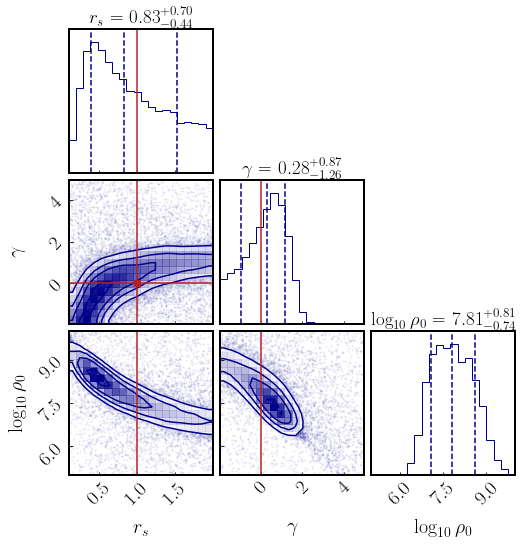

In [91]:
plot_labels = (r'$r_{s}$', r'$\gamma$', r'$\log_{10}\rho_0$')

fig = corner.corner(
    dm_results.samples, weights=dm_weights, truths=truth_dm_params,
    truth_color='firebrick', color='darkblue',
    quantiles=[0.16, 0.5, 0.84],plot_datapoints=True, smooth=True, max_n_ticks=4, 
    show_titles=True, title_kwargs={"fontsize": 19}, 
    labels=plot_labels, fontsize=20
)